<a href="https://colab.research.google.com/github/jshinm/code_bucket/blob/main/DataAugmentation_Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="BrainMachineIcon" height="45px" src="https://www.pngfind.com/pngs/m/360-3602228_mdico-hospital-doentes-e-etc-chest-x-ray.png" align="left" hspace="10px" vspace="0px"></p> 

<h1> Hello there, welcome to Lab 7 of EN.520.659! </h1>

In this lab, we will learn to classify pneumonia using Chest X-Ray dataset which can be downloaded from [here](https://www.dropbox.com/s/cwvaqip12wpex6o/Lab7_XRay_chest_pnemonia.zip?dl=0). This data is already split into train, test and validation directories, so you do not have to split it yourself! (One less task 😜). There are two sub-directories under each directory: `NORMAL` and	`PNEUMONIA`

In this lab, we will learn :
- how to use data augmentation in keras to improve your models 
- visualization using Grad-CAM




# Part I
Train a Convolutional Neural Network (CNN) with and without data augmentation


In [289]:
# YOUR IMPORTS HERE
# Note: ALL the imports you use should be here and not in middle of code
from google.colab import drive
from zipfile import ZipFile
import os
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

#imports for keras and sklearn
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D, ReLU # https://keras.io/api/layers/convolution_layers/convolution1d/
from keras.regularizers import L1, L2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#import for the extra credit
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from skimage import morphology, io, color, exposure, img_as_float, transform

## Task 1: 
Mount Google Drive  [2 points]

In [159]:
# YOUR CODE HERE
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Task 2: 
Define directories for train, test, validation [5 points]

In [160]:
# YOUR CODE HERE
DIRPATH = '/content/drive/MyDrive/JHU_NDD/XRAYdataset/'
FILENAME = 'Lab7_XRay_chest_pneumonia.zip'
TRAIN = 'XRay_chest_pnemonia/train'
VAL = 'XRay_chest_pnemonia/val'
TEST = 'XRay_chest_pnemonia/test'
CLASSES = ['NORMAL', 'PNEUMONIA']

In [161]:
with ZipFile(DIRPATH + FILENAME, 'r') as zipobj:
    zipobj.extractall() 

## Task 3: 
Visualize some images from train set and plot class distribution of all sets using bar plots [6 points]

In [249]:
# YOUR CODE HERE
def get_files(path):
    flist = []
    for i, classes in enumerate(CLASSES): #separately stores different classes into a multi-dimensional list
        for dirpath, dir, files in os.walk(path+'/'+classes): #get all the files
            temp = [i+j for i, j in np.broadcast([path+'/'+classes+'/'],files)] #combine path and filenames by numpy broadcasting
            flist.append(temp)
    
    return flist

ls_train = get_files(TRAIN) #list of files for train
ls_val = get_files(VAL)#list of files for val
ls_test = get_files(TEST)#list of files for test

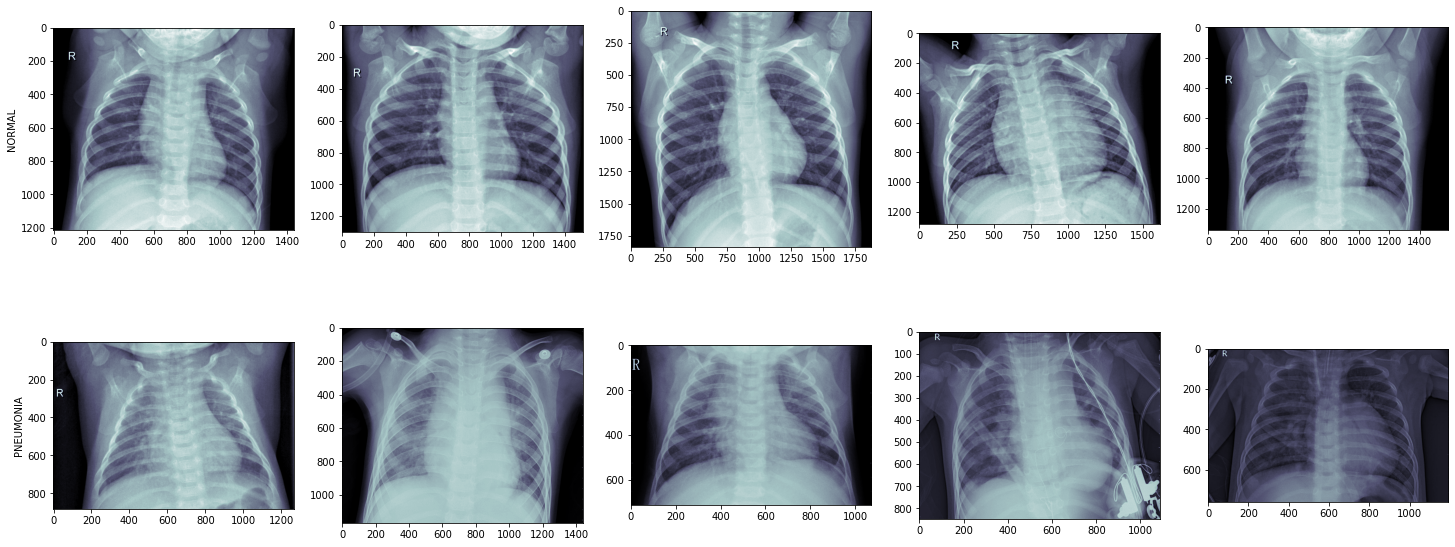

In [250]:
fig, axs = plt.subplots(2,5, figsize=(5*5,5*2))

for i, classes in enumerate(CLASSES):
    temp = pd.DataFrame(ls_train,columns=None).values[i] #equalize embedded list dimensions and convert it into a numpy array
    temp = np.random.choice(temp[temp != None], 5, replace=False) #randomly chooses five images
    for j, f in enumerate(temp):
        if j == 0:
            axs[i,j].set_ylabel(classes) #set y-axis label
        img = plt.imread(f) #read image from a given path
        axs[i,j].imshow(img, cmap='bone') #display image

In [253]:
ls_dist = []

for lst in [ls_train, ls_val, ls_test]:
    ls_dist.append([len(lst[0]),len(lst[1])])

In [254]:
pd.DataFrame(ls_dist, columns=CLASSES, index=['Train', 'Val', 'Test'])

,NORMAL,PNEUMONIA
Train,1341,3875
Val,8,8
Test,234,390


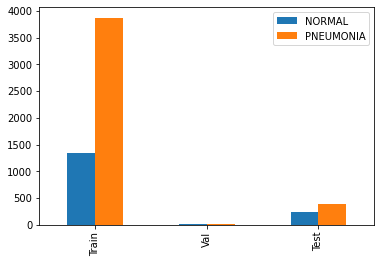

In [255]:
# plt.bar(x=[1,2,3],height=ls_dist)
pd.DataFrame(ls_dist, columns=CLASSES, index=['Train', 'Val', 'Test']).plot(kind='bar')

## Task 4:
Train a Convoluational Neural Network (CNN) using data loaders. **Plot training and validation accuracy and loss in a graph.** What is the model's accuracy on test data? [10 points]

In [564]:
# YOUR CODE HERE
df = []

for dat in [ls_train, ls_val, ls_test]:
    temp = pd.DataFrame(dat,columns=None).T
    df1= temp[0].to_frame().dropna().melt()
    df2= temp[1].to_frame().dropna().melt()
    df.append(df1.append(df2))

In [565]:
X_train, y_train = df[0]['value'], df[0]['variable']
X_val, y_val = df[1]['value'], df[1]['variable']
X_test, y_test = df[2]['value'], df[2]['variable']

In [566]:
df[0]

,variable,value
0,0,XRay_chest_pnemonia/train/NORMAL/NORMAL2-IM-11...
1,0,XRay_chest_pnemonia/train/NORMAL/IM-0185-0001....
2,0,XRay_chest_pnemonia/train/NORMAL/IM-0411-0001....
3,0,XRay_chest_pnemonia/train/NORMAL/IM-0596-0001....
4,0,XRay_chest_pnemonia/train/NORMAL/NORMAL2-IM-12...
...,...,...
3870,1,XRay_chest_pnemonia/train/PNEUMONIA/person1161...
3871,1,XRay_chest_pnemonia/train/PNEUMONIA/person1310...
3872,1,XRay_chest_pnemonia/train/PNEUMONIA/person267_...
3873,1,XRay_chest_pnemonia/train/PNEUMONIA/person1354...


In [568]:
for i in range(3):
    df[i] = df[i].astype(str)

In [340]:
# Redefine generator to include pre-processing function
BS = 50 #batch size

datagen = ImageDataGenerator(rescale=1./255) #normalize

#constructing train,val,test generator from the dataframe as the image cannot fit at once
train_generator = datagen.flow_from_dataframe(df[0], directory='', x_col='value', y_col='variable', class_mode='binary', batch_size=BS, shuffle=True, seed=12345)
val_generator = datagen.flow_from_dataframe(df[1], directory='', x_col='value', y_col='variable', class_mode='binary', batch_size=BS, shuffle=True, seed=12345)
test_generator = datagen.flow_from_dataframe(df[2], directory='', x_col='value', y_col='variable', class_mode='binary', batch_size=BS, shuffle=True, seed=12345)

Found 5216 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [341]:
# Custom CNN Model (There are 3 Conv-MaxPool operations)
model = Sequential()
model.add(Conv2D(256, (5), activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(64, (5), activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(16, (5), activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid', kernel_regularizer=L2(0.02), bias_regularizer=L2(0.02), activity_regularizer=L2(0.02)))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [342]:
history = model.fit(x=train_generator,validation_data=val_generator,verbose=1, epochs=10)

Epoch 1/10
105/105 [==============================] - 72s 620ms/step - loss: 0.6252 - accuracy: 0.7277 - val_loss: 0.5044 - val_accuracy: 0.8125
Epoch 2/10
105/105 [==============================] - 65s 616ms/step - loss: 0.2979 - accuracy: 0.8967 - val_loss: 0.4549 - val_accuracy: 0.8125
Epoch 3/10
105/105 [==============================] - 65s 615ms/step - loss: 0.2484 - accuracy: 0.9188 - val_loss: 0.3374 - val_accuracy: 0.9375
Epoch 4/10
105/105 [==============================] - 65s 617ms/step - loss: 0.2029 - accuracy: 0.9436 - val_loss: 0.2757 - val_accuracy: 0.9375
Epoch 5/10
105/105 [==============================] - 65s 612ms/step - loss: 0.1809 - accuracy: 0.9466 - val_loss: 0.2050 - val_accuracy: 0.9375
Epoch 6/10
105/105 [==============================] - 65s 619ms/step - loss: 0.1724 - accuracy: 0.9540 - val_loss: 0.2991 - val_accuracy: 0.9375
Epoch 7/10
105/105 [==============================] - 65s 620ms/step - loss: 0.1525 - accuracy: 0.9607 - val_loss: 0.2296 - val_ac

In [343]:
_, acc = model.evaluate(test_generator, verbose=True)
print(f'Test Accuracy: {acc * 100}')

13/13 [==============================] - 6s 430ms/step - loss: 0.6753 - accuracy: 0.8013
Test Accuracy: 80.12820482254028


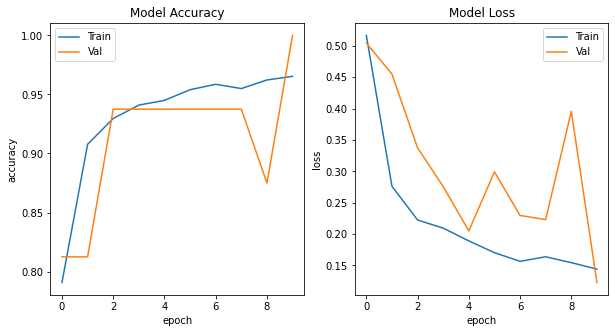

In [344]:
fig, axs = plt.subplots(1,2, figsize=(5*2,5))

axs[0].plot(history.history['accuracy'], label='Train')
axs[0].plot(history.history['val_accuracy'], label='Val')
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend()

axs[1].plot(history.history['loss'], label='Train')
axs[1].plot(history.history['val_loss'], label='Val')
axs[1].set_title('Model Loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend()

In [613]:
y_hat = model.predict_classes(test_generator, verbose=True)
y_hat[y_hat == 0].shape, y_hat[y_hat == 1].shape

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


13/13 [==============================] - 6s 447ms/step


((128,), (496,))

In [366]:
confusion_matrix(test_generator.labels, y_hat)

array([[ 50, 184],
       [ 78, 312]])

In [367]:
print(classification_report(test_generator.labels, y_hat))

              precision    recall  f1-score   support

           0       0.39      0.21      0.28       234
           1       0.63      0.80      0.70       390

    accuracy                           0.58       624
   macro avg       0.51      0.51      0.49       624
weighted avg       0.54      0.58      0.54       624



## Task 5:
Use data-augmentation inbuilt in keras wisely **only for training**. Keep all model parameters same as Task 3 for comparison. [15 points]


> ⏩ Hint: Data augmentation in Keras is very simple when using dataloader. Please carefully select the augmentation parameters in `ImageDataGenerator`. You may want to refer to https://keras.io/api/preprocessing/image/#imagedatagenerator-class for options available.

> Like last lab you have to show performance using accuracy (obtained from keras) and plotting confusion matrix <br>
> ⏩ Hint: You may want to use functions `from sklearn.metrics import confusion_matrix` , `from sklearn.metrics import classification_report`

🔷 Please write in comments why are you using those paramters for augmentation of X-Rays. If you do not write these comments, points will be deducted.

In [576]:
# YOUR CODE HERE
datagen_aug = ImageDataGenerator(rescale=1./255,
                                 rotation_range=10)
                                #    width_shift_range=0.1,
                                #    height_shift_range=0.1,
                                #    zoom_range=0.2,
                                #    fill_mode='nearest',
                                #    cval=0)

#constructing train,val,test generator from the dataframe as the image cannot fit at once
train_generator_aug = datagen_aug.flow_from_dataframe(df[0], directory='', x_col='value', y_col='variable', class_mode='binary', batch_size=BS, shuffle=True, seed=12345)

Found 5216 validated image filenames belonging to 2 classes.


In [577]:
# Custom CNN Model (There are 3 Conv-MaxPool operations)
model_aug = Sequential()
model_aug.add(Conv2D(256, (5), activation='relu'))
model_aug.add(MaxPool2D((2,2)))
model_aug.add(Dropout(0.5))
model_aug.add(Conv2D(64, (5), activation='relu'))
model_aug.add(MaxPool2D((2,2)))
model_aug.add(Dropout(0.5))
model_aug.add(Conv2D(16, (5), activation='relu'))
model_aug.add(MaxPool2D((2,2)))
model_aug.add(Dropout(0.5))
model_aug.add(Flatten())
model_aug.add(Dense(1, activation='sigmoid', kernel_regularizer=L2(0.02), bias_regularizer=L2(0.02), activity_regularizer=L2(0.02)))

model_aug.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [578]:
history_aug = model_aug.fit(x=train_generator_aug,validation_data=val_generator,verbose=1, epochs=10)

Epoch 1/10
105/105 [==============================] - 130s 1s/step - loss: 0.6068 - accuracy: 0.7444 - val_loss: 0.5699 - val_accuracy: 0.8125
Epoch 2/10
105/105 [==============================] - 128s 1s/step - loss: 0.2876 - accuracy: 0.9020 - val_loss: 0.5089 - val_accuracy: 0.8125
Epoch 3/10
105/105 [==============================] - 131s 1s/step - loss: 0.2490 - accuracy: 0.9167 - val_loss: 0.4996 - val_accuracy: 0.7500
Epoch 4/10
105/105 [==============================] - 130s 1s/step - loss: 0.2591 - accuracy: 0.9171 - val_loss: 0.9578 - val_accuracy: 0.6250
Epoch 5/10
105/105 [==============================] - 128s 1s/step - loss: 0.2055 - accuracy: 0.9384 - val_loss: 0.7222 - val_accuracy: 0.6875
Epoch 6/10
105/105 [==============================] - 129s 1s/step - loss: 0.2271 - accuracy: 0.9329 - val_loss: 0.5492 - val_accuracy: 0.8125
Epoch 7/10
105/105 [==============================] - 133s 1s/step - loss: 0.2365 - accuracy: 0.9265 - val_loss: 0.7033 - val_accuracy: 0.6875

In [579]:
_, acc = model_aug.evaluate(test_generator, verbose=True)
print(f'Test Accuracy: {acc * 100}')

13/13 [==============================] - 8s 612ms/step - loss: 0.6763 - accuracy: 0.7644
Test Accuracy: 76.44230723381042


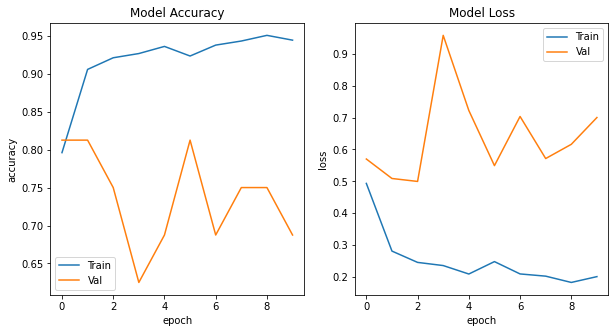

In [580]:
fig, axs = plt.subplots(1,2, figsize=(5*2,5))

axs[0].plot(history_aug.history['accuracy'], label='Train')
axs[0].plot(history_aug.history['val_accuracy'], label='Val')
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend()

axs[1].plot(history_aug.history['loss'], label='Train')
axs[1].plot(history_aug.history['val_loss'], label='Val')
axs[1].set_title('Model Loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend()

In [614]:
y_hat_aug = model_aug.predict_classes(test_generator, verbose=True)
y_hat_aug[y_hat_aug == 0].shape, y_hat_aug[y_hat_aug == 1].shape

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


13/13 [==============================] - 6s 441ms/step


((93,), (531,))

In [582]:
confusion_matrix(test_generator.labels, y_hat_aug)

array([[ 28, 206],
       [ 65, 325]])

In [583]:
print(classification_report(test_generator.labels, y_hat_aug))

              precision    recall  f1-score   support

           0       0.30      0.12      0.17       234
           1       0.61      0.83      0.71       390

    accuracy                           0.57       624
   macro avg       0.46      0.48      0.44       624
weighted avg       0.50      0.57      0.51       624



## Task 6:
Compare results with and without data augmentation. Did it work? Why do you think it worked? Can you display some augmented data? [10 points]

It is interesting to note that base model has performed better than the model that has been trained on the augmented datasets. Judging from the plot for the augmented model, it seems that the model is overfitting to the training set probabily attributed to the fact that the distribution of the augmentation I've implemented deviates from the distribution of the validation and the test sets. This phenomenone is not observed from the base model where both training and test set achieves relatively higher accuracy and lower loss.

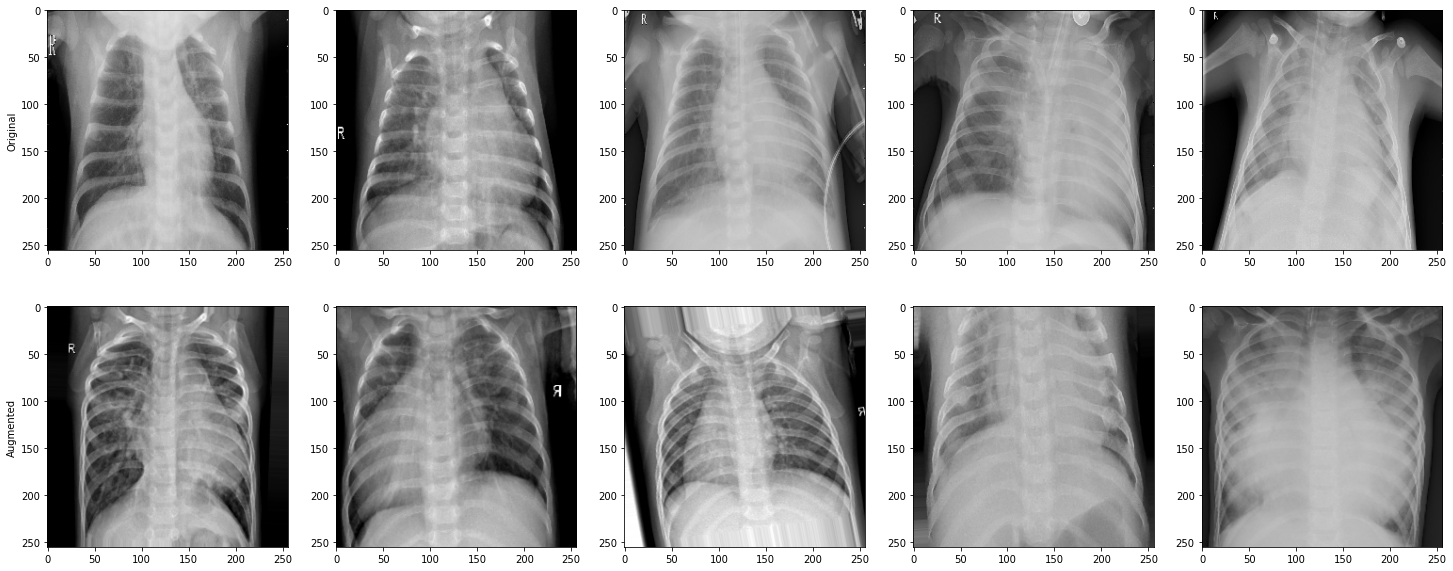

In [414]:
# YOUR CODE HERE
fig, axs = plt.subplots(2,5, figsize=(5*5,5*2))

for i, classes in enumerate(['Original', 'Augmented']):
    for j in range(5):
        if j == 0:
            axs[i,j].set_ylabel(classes) #set y-axis label
        if i == 1:
            axs[i,j].imshow(train_generator_aug[0][0][j], cmap='bone') #display image
        else:
            axs[i,j].imshow(train_generator[0][0][j], cmap='bone') #display image

# Part II
Visualization using Grad-CAM. 



## Task 7:
What is Grad-CAM? Why do you think Grad-CAM is useful? 
Please give a short summary of Grad-CAM (100-200 words) [10 points]

You may want to read the paper here : https://arxiv.org/abs/1610.02391

Grad-CAM is a technique which is designed for visualizing where a convolutional neural network model is "looking" to make prediction, thus making it class-specific heatmap can be generated from any given convolutional neural networks. This technique can be used to gain better understanding of the model and its performance by looking at where in the image is most activated from the heatmap. Lastly, Grad-CAM is a form of post-hoc attention, where production of the heatmap is applied to an already-trained neural network where its parameteres are fixed.

## Task 8:
[15 points]
Visualize 6 samples in test data (3 per class) using Grad-CAM. For every data points, you plot the Grad-CAM image and also mention the predicted and true labels. <br> 

Feel free to use any open-source implementation, but **remember to explain clearly what each part of the code is doing** and cite the link you used the code from. If you do not write appropriate comments and give appropriate credits to original author, points will be deducted. 

## The following code is adapted from Deep Learning with Python (2017)

In [585]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

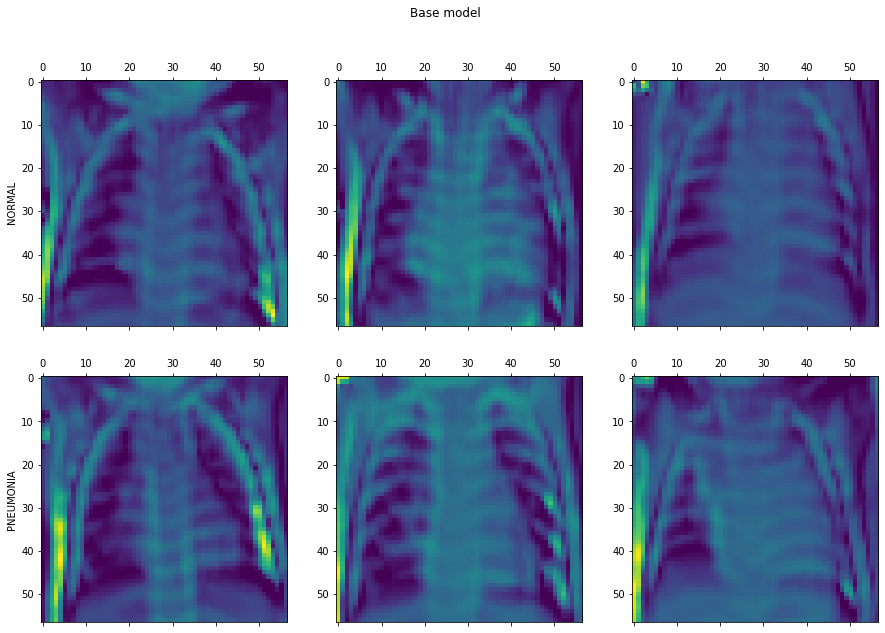

In [687]:
model.layers[-1].activation = None

fig, axs = plt.subplots(2,3,figsize=(5*3,5*2))
last_conv_layer_name = 'conv2d_50'
plt.suptitle('Base model')

for i in range(3):
    for j, lab in enumerate(CLASSES):
        img_array = test_generator[j][0][i:i+1] # Prepare image   
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
        axs[j,i].matshow(heatmap)
        if i == 0:
            axs[j,i].set_ylabel(lab)  

Augmented model

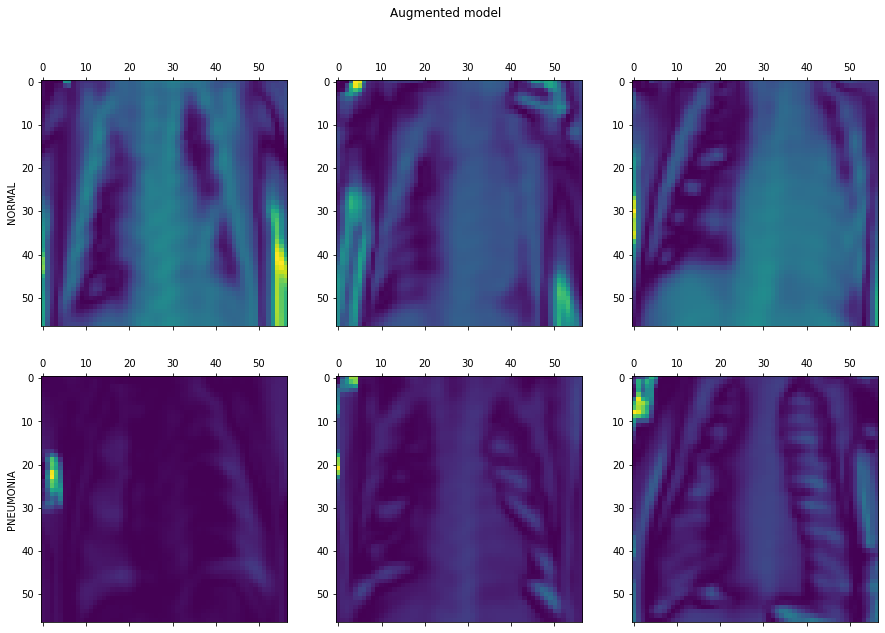

In [605]:
model_aug.layers[-1].activation = None

fig, axs = plt.subplots(2,3,figsize=(5*3,5*2))
last_conv_layer_name = 'conv2d_68'
plt.suptitle('Augmented model')

for i in range(3):
    for j, lab in enumerate(CLASSES):
        img_array = plt.imread(df[2].query(f'variable == "{j}"').loc[i]['value'])
        # img_array = test_generator[j][0][i:i+1] # Prepare image   
        heatmap = make_gradcam_heatmap(img_array, model_aug, last_conv_layer_name)
        axs[j,i].matshow(heatmap)
        if i == 0:
            axs[j,i].set_ylabel(lab)  

# Bonus:
Perform one of the below task
[20 points]

**OPTION I** <br>
> Use lung segmentation as pre-processing to see if such augmentatin helps your models 
<br>

> You can use this for segmentation: https://github.com/imlab-uiip/lung-segmentation-2d

> You can also check this: https://github.com/jdariasl/COVIDNET from this paper: https://ieeexplore.ieee.org/abstract/document/9293268

**OPTION II** <br>
> Use TSNE for visualization of embeddings obtained using model to see if embeddings form seperate clusters. Feel free to use any library.

In [ ]:
'''
Use of data augmentation for training required slight changes to keras ImageDataGenerator. 
Generator in image_gen.py applies same transformation to both the image and the label mask.

To use this implementation one needs to load and preprocess data (see load_data.py), 
train new model if needed (train_model.py) and use the model for generating lung masks (inference.py).

trained_model.hdf5 contains model trained on both data sets mentioned below.
'''

In [456]:
# YOUR CODE HERE
with ZipFile(DIRPATH + 'lung-segmentation-2d-master.zip', 'r') as zipobj:
    zipobj.extractall()

In [546]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

def loadDataGeneral(df, path, im_shape):
    X, y = [], []
    for i, item in df.iterrows():
        img = img_as_float(io.imread(path + item[0]))
        mask = io.imread(path + item[1])
        img = transform.resize(img, im_shape)
        img = exposure.equalize_hist(img)
        img = np.expand_dims(img, -1)
        mask = transform.resize(mask, im_shape)
        mask = np.expand_dims(mask, -1)
        X.append(img)
        y.append(mask)
    X = np.array(X)
    y = np.array(y)
    X -= X.mean()
    X /= X.std()

    print('### Dataset loaded')
    print('\t{}'.format(path))
    print('\t{}\t{}'.format(X.shape, y.shape))
    print('\tX:{:.1f}-{:.1f}\ty:{:.1f}-{:.1f}\n'.format(X.min(), X.max(), y.min(), y.max()))
    print('\tX.mean = {}, X.std = {}'.format(X.mean(), X.std()))
    return X, y

def IoU(y_true, y_pred):
    """Returns Intersection over Union score for ground truth and predicted masks."""
    assert y_true.dtype == bool and y_pred.dtype == bool
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.logical_and(y_true_f, y_pred_f).sum()
    union = np.logical_or(y_true_f, y_pred_f).sum()
    return (intersection + 1) * 1. / (union + 1)

def Dice(y_true, y_pred):
    """Returns Dice Similarity Coefficient for ground truth and predicted masks."""
    assert y_true.dtype == bool and y_pred.dtype == bool
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.logical_and(y_true_f, y_pred_f).sum()
    return (2. * intersection + 1.) / (y_true.sum() + y_pred.sum() + 1.)

def masked(img, gt, mask, alpha=1):
    """Returns image with GT lung field outlined with red, predicted lung field
    filled with blue."""
    rows, cols = img.shape
    color_mask = np.zeros((rows, cols, 3))
    print(morphology.dilation(gt, morphology.disk(3)).shape, gt.shape)
    boundary = morphology.dilation(gt, morphology.disk(3))+0. - gt
    color_mask[mask == 1] = [0, 0, 1]
    color_mask[boundary == 1] = [1, 0, 0]
    img_color = np.dstack((img, img, img))

    img_hsv = color.rgb2hsv(img_color)
    color_mask_hsv = color.rgb2hsv(color_mask)

    img_hsv[..., 0] = color_mask_hsv[..., 0]
    img_hsv[..., 1] = color_mask_hsv[..., 1] * alpha

    img_masked = color.hsv2rgb(img_hsv)
    return img_masked

def remove_small_regions(img, size):
    """Morphologically removes small (less than size) connected regions of 0s or 1s."""
    img = morphology.remove_small_objects(img, size)
    img = morphology.remove_small_holes(img, size)
    return img

### Dataset loaded
	lung-segmentation-2d-master/Demo/Data/
	(4, 256, 256, 1)	(4, 256, 256, 1)
	X:-1.7-1.7	y:0.0-1.0

	X.mean = 8.673617379884035e-17, X.std = 0.9999999999999999
1.jpg 0.959364238410596 0.9792601806284138
(256, 256) (256, 256)
2.jpg 0.9567423876268729 0.977892136681762
(256, 256) (256, 256)
3.jpg 0.954028809363043 0.9764729597419801
(256, 256) (256, 256)
4.jpg 0.9623172576037641 0.9807964033397559
(256, 256) (256, 256)
Mean IoU: 0.958113173251069
Mean Dice: 0.9786054200979779


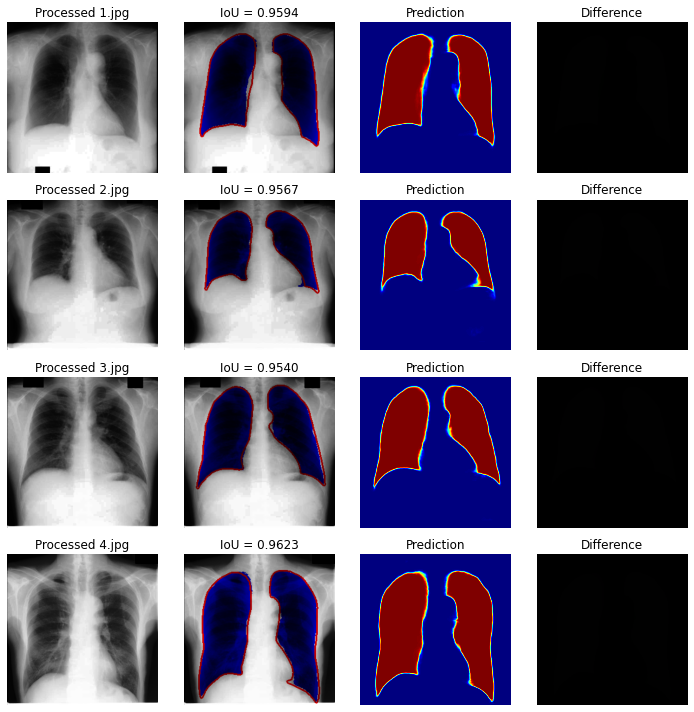

In [547]:
    # Path to csv-file. File should contain X-ray filenames as first column,
    # mask filenames as second column.
    csv_path = 'lung-segmentation-2d-master/Demo/idx.csv'
    # Path to the folder with images. Images will be read from path + path_from_csv
    path = 'lung-segmentation-2d-master/Demo/Data/'

    df = pd.read_csv(csv_path)

    # Load test data
    im_shape = (256, 256)
    X, y = loadDataGeneral(df, path, im_shape)

    n_test = X.shape[0]
    inp_shape = X[0].shape

    # Load model
    model_name = 'lung-segmentation-2d-master/trained_model.hdf5'
    UNet = load_model(model_name)

    # For inference standard keras ImageGenerator can be used.
    test_gen = ImageDataGenerator(rescale=1.)

    ious = np.zeros(n_test)
    dices = np.zeros(n_test)

    gts, prs = [], []
    i = 0
    plt.figure(figsize=(10, 10))
    for xx, yy in test_gen.flow(X, y, batch_size=1):
        img = exposure.rescale_intensity(np.squeeze(xx), out_range=(0,1))
        pred = UNet.predict(xx)[..., 0].reshape(inp_shape[:2])
        mask = yy[..., 0].reshape(inp_shape[:2])

        gt = mask > 0.5
        pr = pred > 0.5

        pr = remove_small_regions(pr, 0.02 * np.prod(im_shape))

        #io.imsave('{}'.format(df.iloc[i].path), masked(img, gt, pr, 1))

        gts.append(gt)
        prs.append(pr)
        ious[i] = IoU(gt, pr)
        dices[i] = Dice(gt, pr)
        print(df.iloc[i][0], ious[i], dices[i])

        if i < 4:
            plt.subplot(4, 4, 4*i+1)
            plt.title('Processed ' + df.iloc[i][0])
            plt.axis('off')
            plt.imshow(img, cmap='gray')

            plt.subplot(4, 4, 4 * i + 2)
            plt.title('IoU = {:.4f}'.format(ious[i]))
            plt.axis('off')
            plt.imshow(masked(img, gt, pr, 1))

            plt.subplot(4, 4, 4*i+3)
            plt.title('Prediction')
            plt.axis('off')
            plt.imshow(pred, cmap='jet')

            plt.subplot(4, 4, 4*i+4)
            plt.title('Difference')
            plt.axis('off')
            plt.imshow(np.dstack((pr.astype(np.int8), gt.astype(np.int8), pr.astype(np.int8))))

        i += 1
        if i == n_test:
            break

    print('Mean IoU:', ious.mean())
    print('Mean Dice:', dices.mean())
    plt.tight_layout()
    plt.savefig('results.png')
    plt.show()

# PART III
Congratulations on finishing the lab 🎉 Enjoy

## Task 9:
[1 point]

Do you enjoy these "congrats" tasks?

=> Most certainly, they worth extra points

[Image source](https://medium.com/analytics-vidhya/data-augmentation-keras-in-nutshell-theory-98c2e865abce)

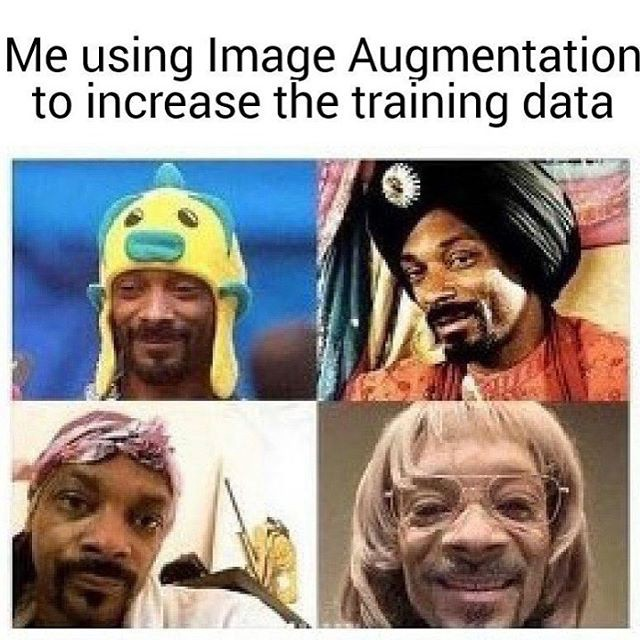